In [3]:
import concurrent.futures
import json
import requests
import os
import s3fs
from rdflib import Graph
import time
from SPARQLWrapper import SPARQLWrapper, BASIC, GET, JSON, N3, POST
s3 = s3fs.S3FileSystem(anon=True)

asset_insert_times=[]
dandiset_insert_times=[]
collection_insert_times=[]
API = "https://api.dandiarchive.org/api/dandisets" 

CONNECTION_DETAILS={
    "hostname":"http://localhost:7200",
    "repository":"test_insert",
    "username":"admin",
    "password":"admin"
}

def replace_quotes(chunk):
    return chunk.replace("'", '"')

def _parallel_replace_quotes(text, chunk_size=100000, num_threads=4):
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        result_chunks = list(executor.map(replace_quotes, chunks))
    return ''.join(result_chunks)

def _get_s3_bucket_url(jsondata): 
    s3_urls = []
    if "results" not in jsondata:
        return []
    
    for i in range(0,len(jsondata["results"])):
        _id = jsondata["results"][i]["identifier"]
        _ver = jsondata["results"][i]["draft_version"]["version"] if jsondata["results"][i]["most_recent_published_version"] == None else jsondata["results"][i]["most_recent_published_version"]["version"]
        url = f's3://dandiarchive/dandisets/{_id}/{_ver}/'
        s3_urls.append(url)
    return s3_urls


def _get_jsonld_file_list_s3(s3url):
    try:
        return list(filter(lambda x: x.endswith('.jsonld'), s3.ls(s3url)))
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def _convert_to_turtle(jsonlddata, export=False, name="data"):
    if export:
        filename = f"{name}.ttl"
        Graph().parse(data=jsonlddata, format='json-ld').serialize(format="turtle", destination=filename)
        return "File exported into turtle format successfully!"
    else:
        return Graph().parse(data=jsonlddata, format='json-ld').serialize(format="turtle")

def _get_export_file_name(file_str):
    split_filestr = file_str.split("/")
    return f"{split_filestr[4].split('.')[0]}_{split_filestr[2]}_{split_filestr[3]}"
    

def _connect_gdb(connection_details, type="get"): 
    username = connection_details["username"]
    password = connection_details["password"]
    if type=="get":
        hostname = f"{connection_details['hostname']}/repositories/{connection_details['repository']}"
    elif type=="post":
        hostname = f"{connection_details['hostname']}/repositories/{connection_details['repository']}/statements"
    sparql = SPARQLWrapper(hostname)
    sparql.setHTTPAuth(BASIC)
    sparql.setCredentials(username, password)
    return sparql

def _insert_data_gdb(connection_details, turtle_data):
    sparql = _connect_gdb(connection_details, "post")
    if sparql: 
        try:
            sparql.setMethod(POST)  
            sparql_query = """
                    INSERT DATA {
                    %s
                    }
                    """%turtle_data 
            sparql.setQuery(sparql_query)
            start_time = time.time() 
            response = sparql.query()  
            end_time = time.time()
            execution_time = f"{end_time - start_time} seconds" 
            print(f"Data inserted successfully! Execution time: {execution_time}")
            return {"status":1, "execution_time":execution_time} 
        except Exception as e:
            print(f"Error occurred: {str(e)}")
            return {"status":0, "execution_time":0} 
    
    else:
        return "Not connected! or Connection error"
    
def __update_global_list_insert_gdb_time(file, timetoadd):
    if "assets.jsonld" in file:
        asset_insert_times.append(timetoadd)
    
    if "collection.jsonld" in file:
        collection_insert_times.append(timetoadd)
    
    if "dandiset.jsonld" in file:
        dandiset_insert_times.append(timetoadd)
 
        
    
def _get_and_convert_turtle_upload(s3_files):
    for file in s3_files:
        print("*"*100)
        export_file_name = _get_export_file_name(file)
        with s3.open(file, 'rb') as f:
            data_js = str(json.load(f))
            modified_text = _parallel_replace_quotes(data_js)
            turtle_data = _convert_to_turtle(modified_text) 
            print(f"Inserting: {file} data")
            response_insert_gdb = _insert_data_gdb(CONNECTION_DETAILS, turtle_data)
            if response_insert_gdb["status"]==1:
                __update_global_list_insert_gdb_time(file, response_insert_gdb["execution_time"])
            print(response_insert_gdb)
        print("*"*100)
    

def start_pipeline(total_pages):
    total_pages = 2 if total_pages <= 1 else total_pages
    for page_num in range(1,total_pages):
        url_dandi_datasets = f"{API}/?pages={page_num}"
        dandi_dataset_info_response = requests.get(url_dandi_datasets)
        if dandi_dataset_info_response.status_code ==200:
            for s3url in (_get_s3_bucket_url(json.loads(dandi_dataset_info_response.text))):
                try:
                    jsonld_files = _get_jsonld_file_list_s3(s3url)
                    if len(jsonld_files)>0:
                        print(f"JSON_LD files: {jsonld_files}")
                        _get_and_convert_turtle_upload(jsonld_files)
                        
                except Exception as e:
                    continue
                    
            else:
                print(f"Unable to get the data: {s3url}")
        
    

In [4]:
start_pipeline(3)


JSON_LD files: ['dandiarchive/dandisets/000003/0.230629.1955/assets.jsonld', 'dandiarchive/dandisets/000003/0.230629.1955/collection.jsonld', 'dandiarchive/dandisets/000003/0.230629.1955/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000003/0.230629.1955/assets.jsonld data
Data inserted successfully! Execution time: 2.1479458808898926 seconds
{'status': 1, 'execution_time': '2.1479458808898926 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000003/0.230629.1955/collection.jsonld data
Data inserted successfully! Execution time: 0.8450162410736084 seconds
{'status': 1, 'execution_time': '0.8450162410736084 seconds'}
**************************************************************************

Data inserted successfully! Execution time: 3.466982841491699 seconds
{'status': 1, 'execution_time': '3.466982841491699 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000010/0.220126.1905/collection.jsonld data
Data inserted successfully! Execution time: 0.47864770889282227 seconds
{'status': 1, 'execution_time': '0.47864770889282227 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000011/0.220126.1907/assets.jsonld', 'dandiarchive/dandisets/000011/0.220126.1907/collection.jsonld', 'dandiarchive/dandisets/000011/0.220126.1907/dandiset.jsonld']
***********************************************

Inserting: dandiarchive/dandisets/000019/0.220126.2148/assets.jsonld data
Data inserted successfully! Execution time: 1.8912239074707031 seconds
{'status': 1, 'execution_time': '1.8912239074707031 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000019/0.220126.2148/collection.jsonld data
Data inserted successfully! Execution time: 0.6291241645812988 seconds
{'status': 1, 'execution_time': '0.6291241645812988 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000020/0.210913.1639/assets.jsonld', 'dandiarchive/dandisets/000020/0.210913.1639/collection.jsonld', 'dandiarchive/dandisets/000020/0.210

Data inserted successfully! Execution time: 1.3295931816101074 seconds
{'status': 1, 'execution_time': '1.3295931816101074 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000027/0.210831.2033/collection.jsonld data
Data inserted successfully! Execution time: 1.467195987701416 seconds
{'status': 1, 'execution_time': '1.467195987701416 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000028/draft/assets.jsonld', 'dandiarchive/dandisets/000028/draft/collection.jsonld', 'dandiarchive/dandisets/000028/draft/dandiset.jsonld']
*************************************************************************

Data inserted successfully! Execution time: 0.1968390941619873 seconds
{'status': 1, 'execution_time': '0.1968390941619873 seconds'}
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000034/0.211030.0713/assets.jsonld', 'dandiarchive/dandisets/000034/0.211030.0713/collection.jsonld', 'dandiarchive/dandisets/000034/0.211030.0713/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000034/0.211030.0713/assets.jsonld data
Data inserted successfully! Execution time: 0.22081899642944336 seconds
{'status': 1, 'execution_time': '0.22081899642944336 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000034/0.211030

Inserting: dandiarchive/dandisets/000041/0.210812.1515/assets.jsonld data
Data inserted successfully! Execution time: 0.31615376472473145 seconds
{'status': 1, 'execution_time': '0.31615376472473145 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000041/0.210812.1515/collection.jsonld data
Data inserted successfully! Execution time: 0.293806791305542 seconds
{'status': 1, 'execution_time': '0.293806791305542 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000042/draft/assets.jsonld', 'dandiarchive/dandisets/000042/draft/collection.jsonld', 'dandiarchive/dandisets/000042/draft/dandiset.jsonld

Inserting: dandiarchive/dandisets/000048/draft/assets.jsonld data
Data inserted successfully! Execution time: 0.18030881881713867 seconds
{'status': 1, 'execution_time': '0.18030881881713867 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000048/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.16640090942382812 seconds
{'status': 1, 'execution_time': '0.16640090942382812 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000049/0.230223.1424/assets.jsonld', 'dandiarchive/dandisets/000049/0.230223.1424/collection.jsonld', 'dandiarchive/dandisets/000049/0.230223.1424/dan

Inserting: dandiarchive/dandisets/000055/0.220127.0436/assets.jsonld data
Data inserted successfully! Execution time: 0.2776460647583008 seconds
{'status': 1, 'execution_time': '0.2776460647583008 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000055/0.220127.0436/collection.jsonld data
Data inserted successfully! Execution time: 0.19653105735778809 seconds
{'status': 1, 'execution_time': '0.19653105735778809 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000056/0.210812.1518/assets.jsonld', 'dandiarchive/dandisets/000056/0.210812.1518/collection.jsonld', 'dandiarchive/dandisets/000056/0.2

Inserting: dandiarchive/dandisets/000065/draft/assets.jsonld data
Data inserted successfully! Execution time: 0.19418787956237793 seconds
{'status': 1, 'execution_time': '0.19418787956237793 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000065/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.1254260540008545 seconds
{'status': 1, 'execution_time': '0.1254260540008545 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000066/draft/assets.jsonld', 'dandiarchive/dandisets/000066/draft/collection.jsonld', 'dandiarchive/dandisets/000066/draft/dandiset.jsonld']
***********

Data inserted successfully! Execution time: 0.9202921390533447 seconds
{'status': 1, 'execution_time': '0.9202921390533447 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000106/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.8725807666778564 seconds
{'status': 1, 'execution_time': '0.8725807666778564 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000107/draft/assets.jsonld', 'dandiarchive/dandisets/000107/draft/collection.jsonld', 'dandiarchive/dandisets/000107/draft/dandiset.jsonld']
*******************************************************************************

Data inserted successfully! Execution time: 2.2372190952301025 seconds
{'status': 1, 'execution_time': '2.2372190952301025 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000115/0.210914.1732/assets.jsonld', 'dandiarchive/dandisets/000115/0.210914.1732/collection.jsonld', 'dandiarchive/dandisets/000115/0.210914.1732/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000115/0.210914.1732/assets.jsonld data
Data inserted successfully! Execution time: 2.6457669734954834 seconds
{'status': 1, 'execution_time': '2.6457669734954834 seconds'}
****************************************************************************************************
***************************************************

Data inserted successfully! Execution time: 0.871344804763794 seconds
{'status': 1, 'execution_time': '0.871344804763794 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000123/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.6412408351898193 seconds
{'status': 1, 'execution_time': '0.6412408351898193 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000124/draft/assets.jsonld', 'dandiarchive/dandisets/000124/draft/collection.jsonld', 'dandiarchive/dandisets/000124/draft/dandiset.jsonld']
*********************************************************************************

Data inserted successfully! Execution time: 0.8673117160797119 seconds
{'status': 1, 'execution_time': '0.8673117160797119 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000131/draft/collection.jsonld data
Data inserted successfully! Execution time: 1.3481168746948242 seconds
{'status': 1, 'execution_time': '1.3481168746948242 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000132/draft/assets.jsonld', 'dandiarchive/dandisets/000132/draft/collection.jsonld', 'dandiarchive/dandisets/000132/draft/dandiset.jsonld']
*******************************************************************************

Inserting: dandiarchive/dandisets/000139/0.220113.0408/assets.jsonld data
Data inserted successfully! Execution time: 0.9504187107086182 seconds
{'status': 1, 'execution_time': '0.9504187107086182 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000139/0.220113.0408/collection.jsonld data
Data inserted successfully! Execution time: 1.1230862140655518 seconds
{'status': 1, 'execution_time': '1.1230862140655518 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000140/0.220113.0408/assets.jsonld', 'dandiarchive/dandisets/000140/0.220113.0408/collection.jsonld', 'dandiarchive/dandisets/000140/0.220

Inserting: dandiarchive/dandisets/000008/0.211014.0809/collection.jsonld data
Data inserted successfully! Execution time: 1.2333917617797852 seconds
{'status': 1, 'execution_time': '1.2333917617797852 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000009/0.220126.1903/assets.jsonld', 'dandiarchive/dandisets/000009/0.220126.1903/collection.jsonld', 'dandiarchive/dandisets/000009/0.220126.1903/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000009/0.220126.1903/assets.jsonld data
Data inserted successfully! Execution time: 3.5360069274902344 seconds
{'status': 1, 'execution_time': '3.5360069274902344 seconds'}
**************************************************************************

Inserting: dandiarchive/dandisets/000017/draft/assets.jsonld data
Data inserted successfully! Execution time: 3.0282669067382812 seconds
{'status': 1, 'execution_time': '3.0282669067382812 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000017/draft/collection.jsonld data
Data inserted successfully! Execution time: 1.1594419479370117 seconds
{'status': 1, 'execution_time': '1.1594419479370117 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000018/draft/assets.jsonld', 'dandiarchive/dandisets/000018/draft/collection.jsonld', 'dandiarchive/dandisets/000018/draft/dandiset.jsonld']
*************

Data inserted successfully! Execution time: 0.21334409713745117 seconds
{'status': 1, 'execution_time': '0.21334409713745117 seconds'}
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000025/draft/assets.jsonld', 'dandiarchive/dandisets/000025/draft/collection.jsonld', 'dandiarchive/dandisets/000025/draft/dandiset.jsonld']
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000026/draft/assets.jsonld', 'dandiarchive/dandisets/000026/draft/collection.jsonld', 'dandiarchive/dandisets/000026/draft/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000026/draft/assets.jsonld data
Error occurred: <urlopen error [Errno 32] Broken pipe>
{'status': 0, 'execution_time': 0}
********************************************

Data inserted successfully! Execution time: 1.1982641220092773 seconds
{'status': 1, 'execution_time': '1.1982641220092773 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000032/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.9085109233856201 seconds
{'status': 1, 'execution_time': '0.9085109233856201 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000033/draft/assets.jsonld', 'dandiarchive/dandisets/000033/draft/collection.jsonld', 'dandiarchive/dandisets/000033/draft/dandiset.jsonld']
*******************************************************************************

Inserting: dandiarchive/dandisets/000039/0.230223.1216/assets.jsonld data
Data inserted successfully! Execution time: 3.3108808994293213 seconds
{'status': 1, 'execution_time': '3.3108808994293213 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000039/0.230223.1216/collection.jsonld data
Data inserted successfully! Execution time: 0.9911320209503174 seconds
{'status': 1, 'execution_time': '0.9911320209503174 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000040/draft/assets.jsonld', 'dandiarchive/dandisets/000040/draft/collection.jsonld', 'dandiarchive/dandisets/000040/draft/dandiset.jsonld

Data inserted successfully! Execution time: 0.762394905090332 seconds
{'status': 1, 'execution_time': '0.762394905090332 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000046/draft/dandiset.jsonld data
Data inserted successfully! Execution time: 0.8181278705596924 seconds
{'status': 1, 'execution_time': '0.8181278705596924 seconds'}
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000047/draft/assets.jsonld', 'dandiarchive/dandisets/000047/draft/collection.jsonld', 'dandiarchive/dandisets/000047/draft/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000047/draft/assets.jsonld data
Data inserted suc

Inserting: dandiarchive/dandisets/000053/0.210819.0345/assets.jsonld data
Data inserted successfully! Execution time: 7.861900806427002 seconds
{'status': 1, 'execution_time': '7.861900806427002 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000053/0.210819.0345/collection.jsonld data
Data inserted successfully! Execution time: 1.1182661056518555 seconds
{'status': 1, 'execution_time': '1.1182661056518555 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000054/0.210819.1547/assets.jsonld', 'dandiarchive/dandisets/000054/0.210819.1547/collection.jsonld', 'dandiarchive/dandisets/000054/0.21081

Data inserted successfully! Execution time: 0.8353099822998047 seconds
{'status': 1, 'execution_time': '0.8353099822998047 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000063/draft/dandiset.jsonld data
Data inserted successfully! Execution time: 0.7379910945892334 seconds
{'status': 1, 'execution_time': '0.7379910945892334 seconds'}
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000064/0.221025.1735/assets.jsonld', 'dandiarchive/dandisets/000064/0.221025.1735/collection.jsonld', 'dandiarchive/dandisets/000064/0.221025.1735/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000064/0.221025.1735/as

Data inserted successfully! Execution time: 0.8171341419219971 seconds
{'status': 1, 'execution_time': '0.8171341419219971 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000072/draft/dandiset.jsonld data
Data inserted successfully! Execution time: 1.0216710567474365 seconds
{'status': 1, 'execution_time': '1.0216710567474365 seconds'}
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000105/draft/assets.jsonld', 'dandiarchive/dandisets/000105/draft/collection.jsonld', 'dandiarchive/dandisets/000105/draft/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000105/draft/assets.jsonld data
Data inserted s

Data inserted successfully! Execution time: 0.9939260482788086 seconds
{'status': 1, 'execution_time': '0.9939260482788086 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000113/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.6519501209259033 seconds
{'status': 1, 'execution_time': '0.6519501209259033 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000113/draft/dandiset.jsonld data
Data inserted successfully! Execution time: 0.552236795425415 seconds
{'status': 1, 'execution_time': '0.552236795425415 seconds'}
*************************************************************

Data inserted successfully! Execution time: 0.5519540309906006 seconds
{'status': 1, 'execution_time': '0.5519540309906006 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000122/draft/assets.jsonld', 'dandiarchive/dandisets/000122/draft/collection.jsonld', 'dandiarchive/dandisets/000122/draft/dandiset.jsonld']
****************************************************************************************************
Inserting: dandiarchive/dandisets/000122/draft/assets.jsonld data
Data inserted successfully! Execution time: 0.6596357822418213 seconds
{'status': 1, 'execution_time': '0.6596357822418213 seconds'}
****************************************************************************************************
***********************************************************************************

Inserting: dandiarchive/dandisets/000129/draft/assets.jsonld data
Data inserted successfully! Execution time: 0.7309367656707764 seconds
{'status': 1, 'execution_time': '0.7309367656707764 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000129/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.8333299160003662 seconds
{'status': 1, 'execution_time': '0.8333299160003662 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000130/0.220113.0407/assets.jsonld', 'dandiarchive/dandisets/000130/0.220113.0407/collection.jsonld', 'dandiarchive/dandisets/000130/0.220113.0407/dandise

Data inserted successfully! Execution time: 0.8244400024414062 seconds
{'status': 1, 'execution_time': '0.8244400024414062 seconds'}
****************************************************************************************************
****************************************************************************************************
Inserting: dandiarchive/dandisets/000137/draft/collection.jsonld data
Data inserted successfully! Execution time: 0.7550280094146729 seconds
{'status': 1, 'execution_time': '0.7550280094146729 seconds'}
****************************************************************************************************
****************************************************************************************************
JSON_LD files: ['dandiarchive/dandisets/000138/0.220113.0407/assets.jsonld', 'dandiarchive/dandisets/000138/0.220113.0407/collection.jsonld', 'dandiarchive/dandisets/000138/0.220113.0407/dandiset.jsonld']
*******************************************************

In [11]:
print(asset_insert_times)

['2.1479458808898926 seconds', '3.154557943344116 seconds', '3.0684640407562256 seconds', '1.7856247425079346 seconds', '3.3101999759674072 seconds', '4.698737144470215 seconds', '3.466982841491699 seconds', '2.6883628368377686 seconds', '5.717873811721802 seconds', '1.7382519245147705 seconds', '3.8661909103393555 seconds', '3.237443208694458 seconds', '1.5956709384918213 seconds', '0.7700450420379639 seconds', '1.8912239074707031 seconds', '5.328527927398682 seconds', '3.1890039443969727 seconds', '7.473453044891357 seconds', '0.7573728561401367 seconds', '1.3295931816101074 seconds', '0.7401549816131592 seconds', '1.5033810138702393 seconds', '1.0796699523925781 seconds', '1.3996658325195312 seconds', '0.7565371990203857 seconds', '0.8324470520019531 seconds', '0.22081899642944336 seconds', '0.6864087581634521 seconds', '0.2352008819580078 seconds', '0.5331840515136719 seconds', '0.2194347381591797 seconds', '0.4939148426055908 seconds', '0.1726689338684082 seconds', '0.316153764724

In [7]:
print(dandiset_insert_times)

['0.5286178588867188 seconds',
 '1.216506004333496 seconds',
 '0.9199109077453613 seconds',
 '2.343262195587158 seconds',
 '0.1968390941619873 seconds',
 '0.1634979248046875 seconds',
 '0.23891401290893555 seconds',
 '0.17870783805847168 seconds',
 '0.20820307731628418 seconds',
 '0.18317604064941406 seconds',
 '0.19064879417419434 seconds',
 '0.16712689399719238 seconds',
 '0.25423526763916016 seconds',
 '0.1863851547241211 seconds',
 '0.8305258750915527 seconds',
 '2.0034711360931396 seconds',
 '0.7936570644378662 seconds',
 '1.2189180850982666 seconds',
 '0.21334409713745117 seconds',
 '2.4026641845703125 seconds',
 '0.6323273181915283 seconds',
 '0.7587890625 seconds',
 '0.8241019248962402 seconds',
 '0.7805497646331787 seconds',
 '0.9923210144042969 seconds',
 '0.8181278705596924 seconds',
 '1.0187273025512695 seconds',
 '0.7657918930053711 seconds',
 '1.0409610271453857 seconds',
 '0.727851152420044 seconds',
 '0.7379910945892334 seconds',
 '1.5616459846496582 seconds',
 '1.02167

In [12]:
print(collection_insert_times)

['0.8450162410736084 seconds', '0.5403499603271484 seconds', '0.9393572807312012 seconds', '0.9622669219970703 seconds', '0.9965927600860596 seconds', '1.2485601902008057 seconds', '1.5896971225738525 seconds', '0.47864770889282227 seconds', '1.001007080078125 seconds', '0.5236330032348633 seconds', '1.044985055923462 seconds', '1.6297619342803955 seconds', '0.6713590621948242 seconds', '0.9023411273956299 seconds', '0.8391861915588379 seconds', '0.6291241645812988 seconds', '1.6784217357635498 seconds', '1.72170090675354 seconds', '0.8797597885131836 seconds', '1.0775728225708008 seconds', '0.6023941040039062 seconds', '1.467195987701416 seconds', '0.7798469066619873 seconds', '1.0419960021972656 seconds', '1.476457118988037 seconds', '2.5592401027679443 seconds', '1.4311187267303467 seconds', '0.24437904357910156 seconds', '0.1903219223022461 seconds', '0.30867505073547363 seconds', '0.20142698287963867 seconds', '0.2283022403717041 seconds', '0.2163240909576416 seconds', '0.22345900

In [13]:
# Convert to double
collection_time_double = [float(time.split(' ')[0]) for time in collection_insert_times]
asset_time_double = [float(time.split(' ')[0]) for time in asset_insert_times]
dandiset_time_double = [float(time.split(' ')[0]) for time in dandiset_insert_times]


In [44]:
def plot(data, title, label_txt, filename):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(rc={'figure.figsize':(20,11)}) 
    # Sample data
    x = range(1,len(data)+1) 
    y = data

    # Plotting lines with marker points
    plt.plot(x, data, marker='x', linestyle='--', color='b', label=label_txt) 

    # Adding labels and title
    plt.xlabel('N#', fontsize=30)
    plt.ylabel('Execution time (Seconds)', fontsize=30)
    plt.title(title, fontsize=30)
    plt.xticks(fontsize=15) 
    plt.yticks(fontsize=15)  
    plt.savefig(f"{filename}.png")

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

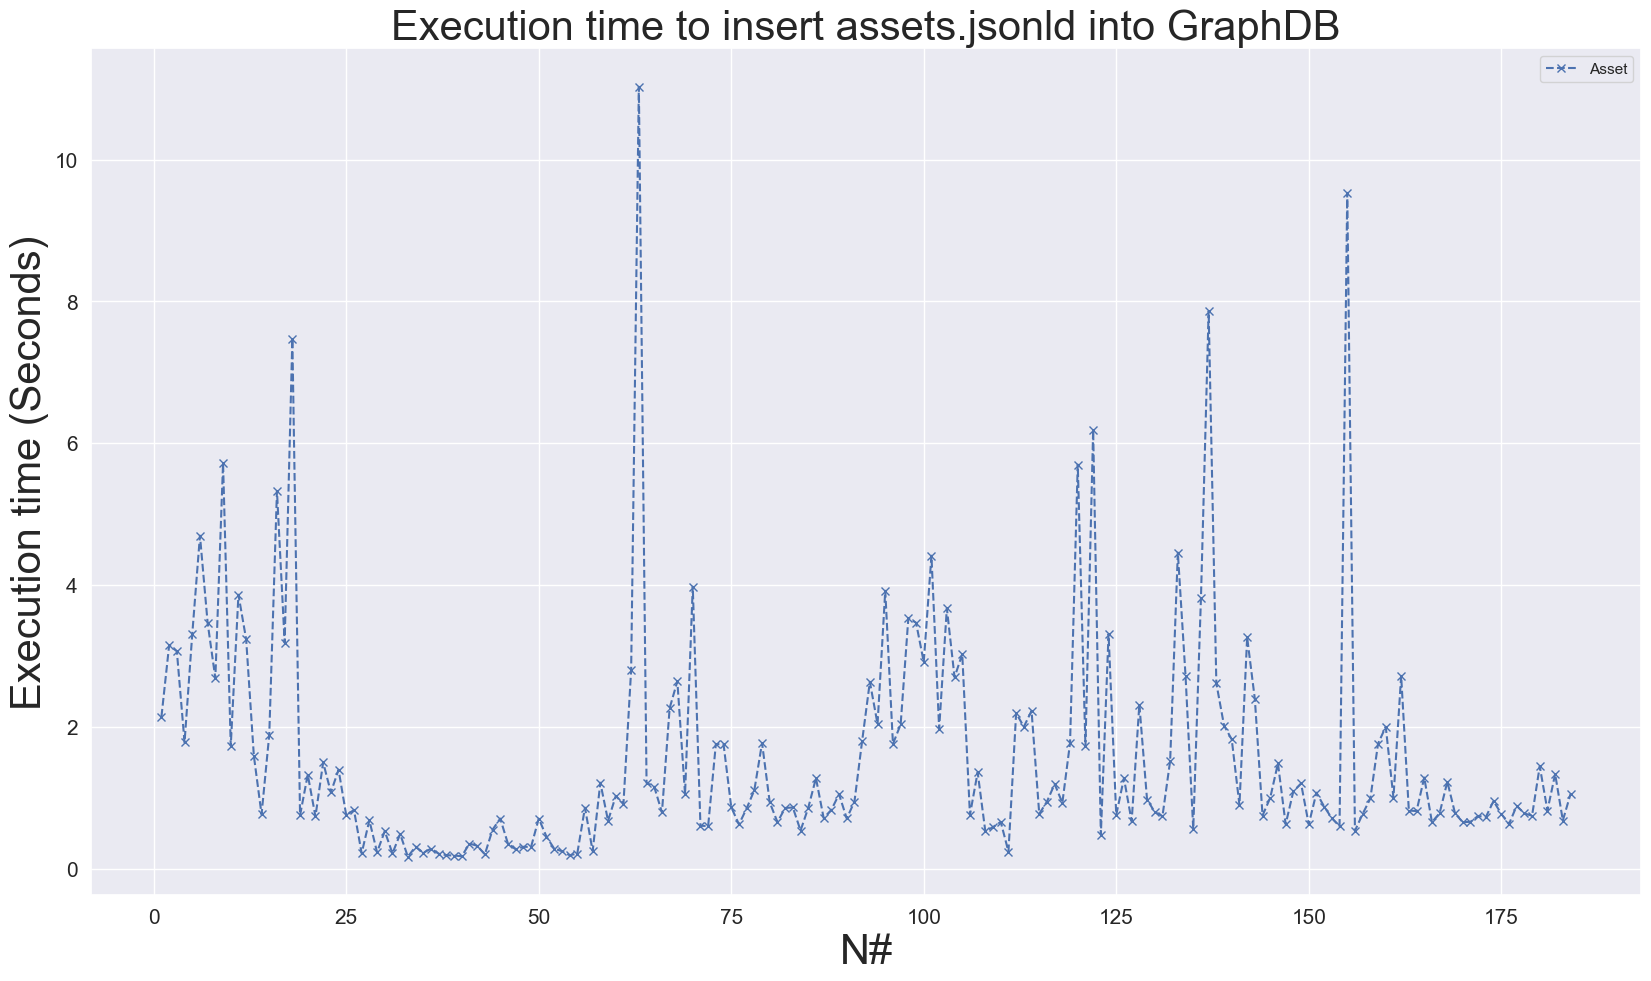

In [47]:
plot(asset_time_double,"Execution time to insert assets.jsonld into GraphDB", 
     "Asset", "asset_performance_plot")

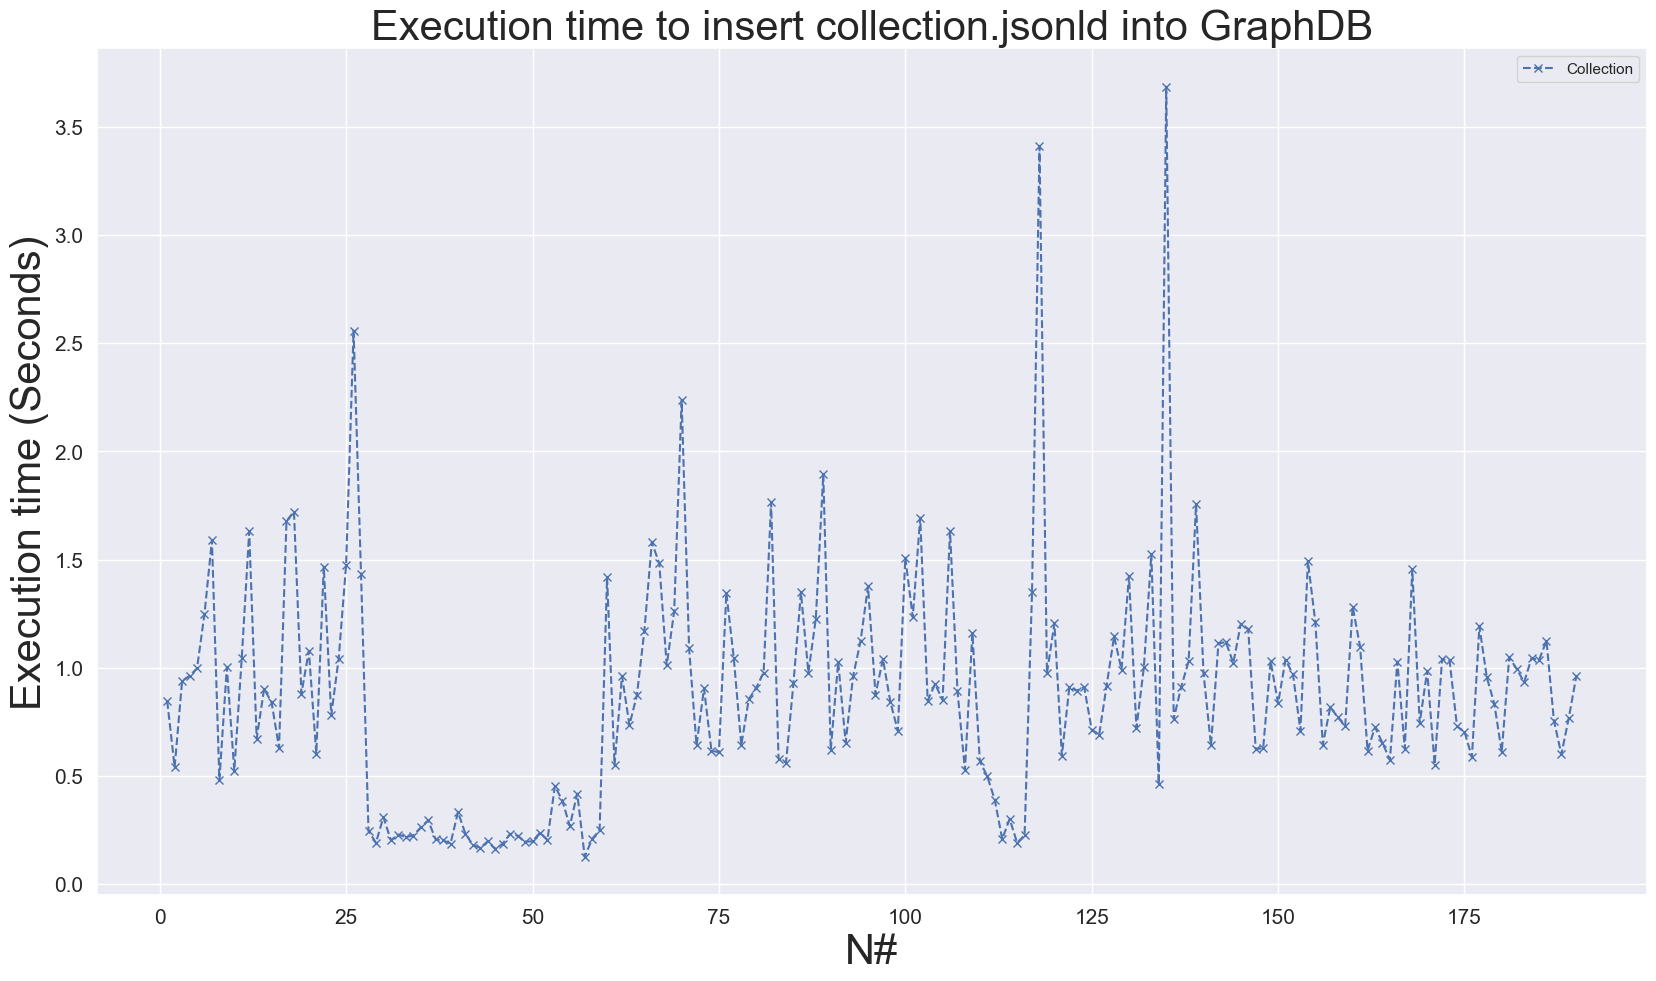

In [48]:
plot(collection_time_double,"Execution time to insert collection.jsonld into GraphDB", 
     "Collection", "collection_performance_plot")

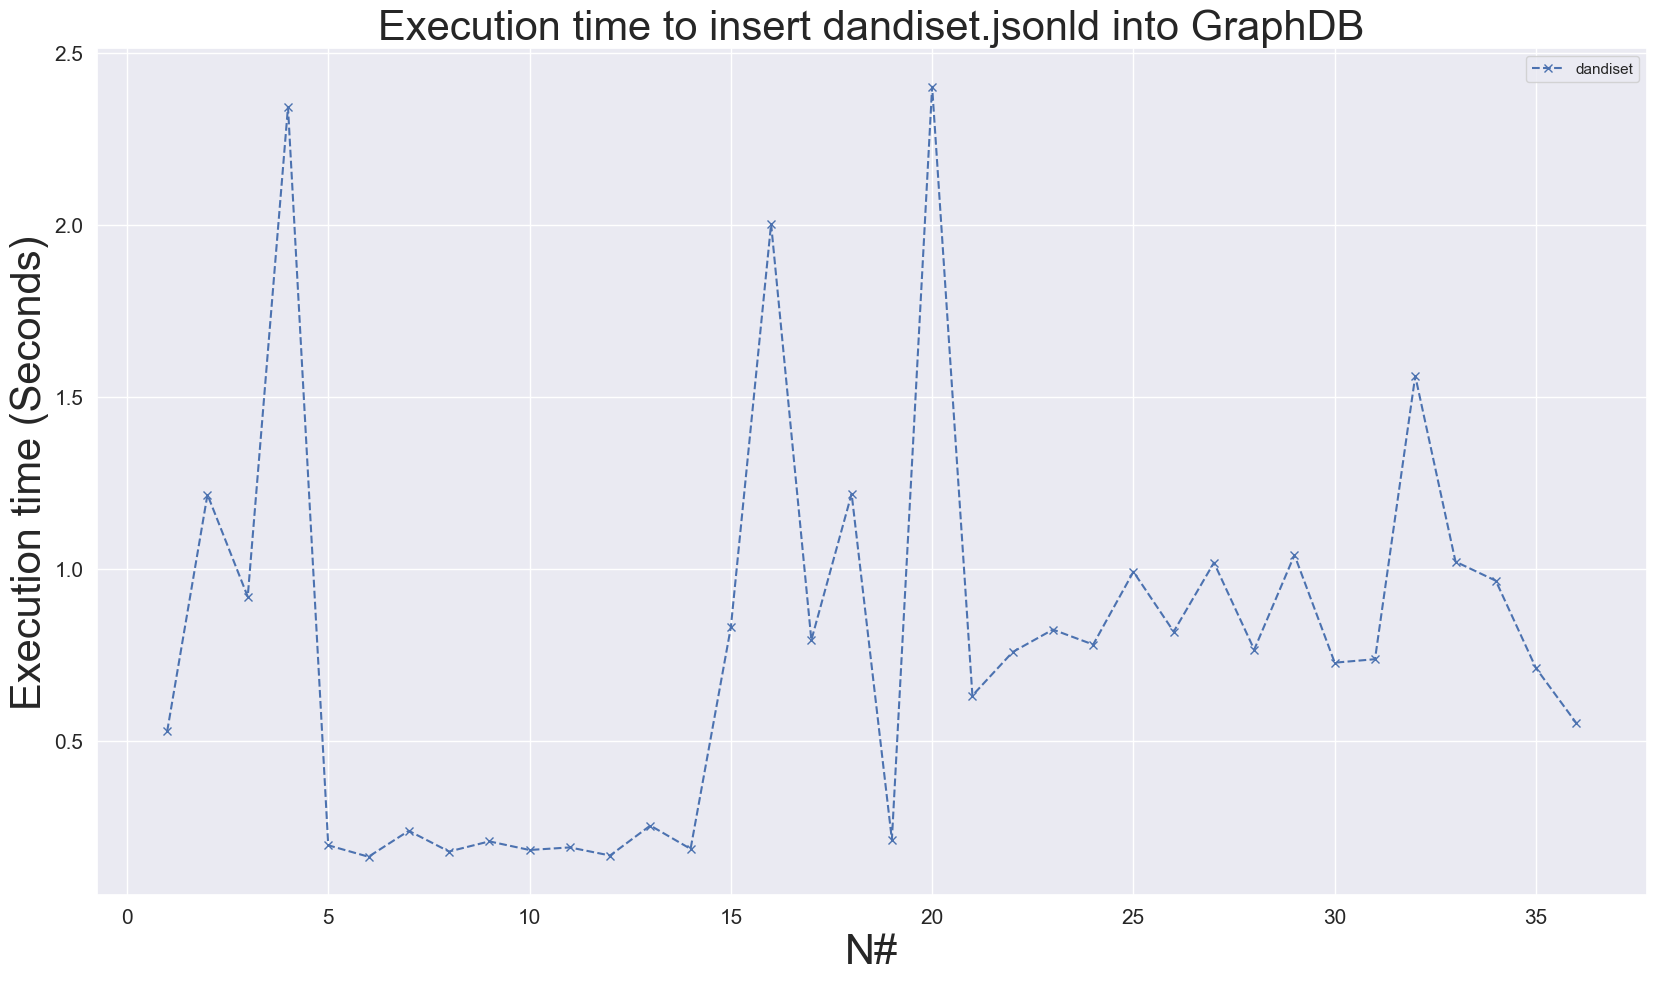

In [49]:
plot(dandiset_time_double,"Execution time to insert dandiset.jsonld into GraphDB",
     "dandiset", "dandiset_performance_plot")